<a href="https://colab.research.google.com/github/benedettoscala/ifttt-code-generator/blob/main/bart_nl2ifttt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup
In this section, we install the necessary dependencies for the notebook. The libraries `evaluate` and `rouge_score` are installed to facilitate text evaluation, particularly for computing ROUGE scores, which are commonly used for assessing the quality of text generation models.



In [1]:
!pip install evaluate
!pip install rouge_score


### Repository Cloning and Setup
We clone the `ifttt-code-generator` repository from GitHub, which contains the required code for this project. After cloning, we navigate into the repository directory and pull the latest changes to ensure we have the most up-to-date version.

In [2]:
!git clone https://github.com/benedettoscala/ifttt-code-generator
%cd ifttt-code-generator/
!git pull

fatal: destination path 'ifttt-code-generator' already exists and is not an empty directory.
/content/ifttt-code-generator
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 428 bytes | 10.00 KiB/s, done.
From https://github.com/benedettoscala/ifttt-code-generator
   97e9ba9..2d027a2  main       -> origin/main
Updating 97e9ba9..2d027a2
Fast-forward
 nl2gpt2.ipynb | 26 +++++++++++++++++++++++++-
 1 file changed, 25 insertions(+), 1 deletion(-)


### Dataset Processing and Tokenization
This section of the notebook performs dataset loading, cleaning, and tokenization using the `facebook/bart-large` tokenizer.

- First, the necessary libraries (`pandas`, `numpy`, `matplotlib.pyplot`, and `transformers`) are imported.
- The `facebook/bart-large` tokenizer is loaded, and if no padding token is defined, it is set to the EOS token.
- A dataset is loaded from a CSV file (`datasets/cleaned_and_combined.csv`), and data cleaning is applied by removing missing values and duplicate entries in the relevant columns.
- Each sample in the dataset is tokenized separately for the description, code, and the combined text using a separator (`\n###\n`).
- Token length statistics (min, max, mean, and median) are computed for the description, code, and full text.
- Finally, a histogram is plotted to visualize the distribution of token lengths in the dataset, with a reference line at 256 tokens to help assess token length constraints.


Statistiche per la descrizione:
  Min: 6
  Max: 63
  Media: 25.476190476190474
  Mediana: 24.0

Statistiche per il codice:
  Min: 16
  Max: 177
  Media: 69.81547619047619
  Mediana: 61.5

Statistiche per il testo completo (descrizione + codice):
  Min: 28
  Max: 197
  Media: 96.29166666666667
  Mediana: 88.0



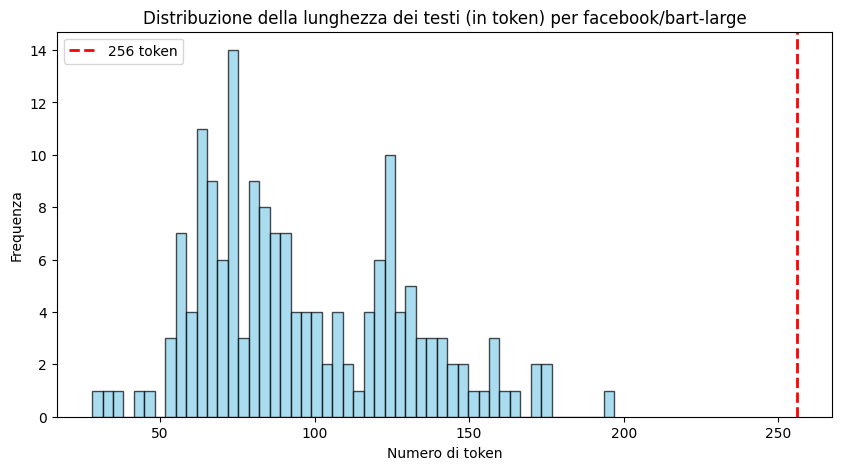

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Imposta il checkpoint del modello (BART-large)
model_checkpoint = "facebook/bart-large"

# Carica il tokenizer per facebook/bart-large
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Se il tokenizer non ha un token di padding definito, impostalo uguale al token EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Carica il dataset
csv_path = "datasets/cleaned_and_combined.csv"
df = pd.read_csv(csv_path)

# Rimuovi righe con valori mancanti e duplicati nelle colonne di interesse
df.dropna(subset=["cleaned_description", "filter_code"], inplace=True)
df.drop_duplicates(subset=["cleaned_description", "filter_code"], inplace=True)

# Definisci un separatore per unire descrizione e codice
separator = "\n###\n"

# Liste per salvare le lunghezze in token
description_lengths = []
code_lengths = []
combined_lengths = []

# Itera su ogni esempio nel dataset
for _, row in df.iterrows():
    description = row["cleaned_description"]
    code = row["filter_code"]

    # Tokenizza la descrizione senza troncamento
    desc_tokens = tokenizer.encode(description, truncation=False)
    # Tokenizza il codice senza troncamento
    code_tokens = tokenizer.encode(code, truncation=False)
    # Tokenizza la concatenazione: descrizione + separatore + codice
    combined_text = description + separator + code
    combined_tokens = tokenizer.encode(combined_text, truncation=False)

    # Salva le lunghezze
    description_lengths.append(len(desc_tokens))
    code_lengths.append(len(code_tokens))
    combined_lengths.append(len(combined_tokens))

# Funzione per stampare statistiche (min, max, media, mediana)
def print_stats(name, lengths):
    print(f"Statistiche per {name}:")
    print("  Min:", np.min(lengths))
    print("  Max:", np.max(lengths))
    print("  Media:", np.mean(lengths))
    print("  Mediana:", np.median(lengths))
    print()

print_stats("la descrizione", description_lengths)
print_stats("il codice", code_lengths)
print_stats("il testo completo (descrizione + codice)", combined_lengths)

# Visualizza la distribuzione della lunghezza in token del testo completo
plt.figure(figsize=(10, 5))
plt.hist(combined_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(256, color='red', linestyle='dashed', linewidth=2, label="256 token")
plt.title("Distribuzione della lunghezza dei testi (in token) per facebook/bart-large")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

### Import Libraries

In [4]:
from transformers import AutoTokenizer, BartForConditionalGeneration
from datasets import load_dataset,load_from_disk
import torch
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize

### Preprocessing Data

In [5]:
import os

In [6]:
%cd ..

/content


### Dataset Loading and Splitting
This section of the notebook loads and processes the dataset for training and evaluation.

- The dataset is loaded from a CSV file using `pandas`.
- Data cleaning is applied by removing missing values and duplicate entries in the `cleaned_description` and `filter_code` columns.
- The dataset is then split into training (80%) and testing (20%) subsets using `train_test_split`, ensuring reproducibility with a fixed random seed (`random_state=42`).
- The `pandas` DataFrames are converted into Hugging Face `Dataset` objects for better compatibility with NLP models.
- Finally, the dataset is structured into a `DatasetDict`, which organizes the training and testing sets for further processing.

The number of examples in the training and test sets is printed at the end to confirm the split.


In [7]:
base_path = os.getcwd()
absolute_path = os.path.join(base_path,r'ifttt-code-generator/datasets/cleaned_and_combined.csv')

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict

# Caricamento del dataset
csv_path = "ifttt-code-generatordatasets/cleaned_and_combined.csv"
df = pd.read_csv(absolute_path)

#droppa i duplicati e i valori nulli se ci sono
df.dropna(subset=["cleaned_description", "filter_code"], inplace=True)
df.drop_duplicates(subset=["cleaned_description", "filter_code"], inplace=True)

# Suddivisione in train e test set (80%-20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convertiamo i DataFrame in Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Stampa delle dimensioni dei set di training e test
print("Train set size:", len(dataset["train"]))
print("Test set size:", len(dataset["test"]))

Train set size: 134
Test set size: 34


In [9]:
model_checkpoint = "facebook/bart-large"

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Model Tokenization and Preprocessing
In this section, we define the tokenizer and preprocess the dataset for training.

- The `facebook/bart-large` tokenizer is loaded using `AutoTokenizer.from_pretrained`.
- We define the maximum input length (256 tokens) and target length (128 tokens) to ensure that text sequences fit within the model's constraints.
- A prefix (`ifttt_prompt: `) is added to each description to provide context for the model.
- The `preprocess_function` tokenizes the descriptions (`cleaned_description`) and corresponding code snippets (`filter_code`), ensuring that they respect the defined token limits and truncation settings.
- The labels (target sequences) are tokenized separately, and their token IDs are stored within the model input structure.
- Finally, the preprocessing function is applied to the dataset using `.map()` to tokenize all data efficiently.

The progress bars at the bottom confirm that the dataset has been successfully tokenized.


In [11]:
max_input_length = 256
max_target_length = 128
prefix1 = "ifttt_prompt: "
prefix2 = " ifttt_context: "


def preprocess_function(examples):
    model_inputs = tokenizer([prefix1 + prompt for prompt in examples['cleaned_description']],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples['filter_code'], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

### Evaluation Metrics Setup
In this section, we load three commonly used evaluation metrics for text generation tasks using the `evaluate` library:

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** Measures overlap between generated text and reference text based on n-grams and longest common subsequence. It is widely used for summarization tasks.
- **BLEU (Bilingual Evaluation Understudy):** Computes precision-based similarity by comparing generated text with reference translations. It is commonly used in machine translation.
- **METEOR (Metric for Evaluation of Translation with Explicit ORdering):** Improves upon BLEU by considering synonym matching, stemming, and word order to provide a more nuanced evaluation.

These metrics will be used to assess the quality of model-generated text by comparing it with ground-truth references.


In [13]:
import evaluate

rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Model Initialization
In this section, we load and configure the model for sequence-to-sequence learning.

- The `facebook/bart-large` model is loaded using `AutoModelForSeq2SeqLM.from_pretrained()`, which retrieves a pre-trained sequence-to-sequence model.
- The generation parameters are set:
  - `max_new_tokens = 128`: The model can generate up to 128 tokens per output.
  - `min_new_tokens = 5`: The model must generate at least 5 tokens.
- These settings are applied both through `generation_config` and `config` to ensure consistency.

Once the model is loaded, we can use it for text generation tasks.



In [14]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [15]:
model.generation_config.max_new_tokens = 128
model.generation_config.min_new_tokens = 5
model.config.max_new_tokens = 128
model.config.min_new_tokens = 5

In [16]:
print(model.config)

BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-large",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

In [17]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "max_new_tokens": 128,
  "min_new_tokens": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}




### Data Collator
This section prepares the data for training by using a data collator.

- `DataCollatorForSeq2Seq` is initialized with the tokenizer and model to dynamically pad inputs to the longest sequence in a batch, improving computational efficiency.
- Unnecessary columns from the tokenized dataset are removed to ensure compatibility with the model.
- A sample batch of two training examples is processed through the data collator, demonstrating the transformation into tensor format.

The data collator ensures that input sequences are properly formatted and padded for efficient batch processing.


In [18]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [19]:
tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [20]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[    0,  1594,  5967,    90,  1215, 12501,  3320,    35, 10683,  2512,
            10,  7127,   515,     7,  8736,    47,     7,   244,   110,  4716,
          3042,    49,  1940,  1175,     4,     2,     1,     1,     1],
        [    0,  1594,  5967,    90,  1215, 12501,  3320,    35,   318,   821,
         11762,    34,    41,   515,  1440,    22, 21461,   113,   278,     5,
         19722,  2413,  1942,     7,   409,   454,  3868,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'labels': tensor([[    0, 10806,  1946,  5457, 37622,     4, 45043, 14699,     4,  4509,
         43048,  1437, 15747,  2289,  5457, 37622,     4, 45043, 14699,     4,
          4530, 43048,  1437, 15747,    86, 40215,  5457,   706,  1437,  1437,
          1437,   114,  1640,  4509,   207,

#### Post Processing for ROUGE computation

In [21]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [22]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Training and Evaluation Loop
This section defines the main training and evaluation loop for the model.

#### **Training Process**
- The model is set to training mode (`model.train()`).
- The loss is tracked for each batch, and backpropagation is performed using `accelerator.backward(loss)`.
- The optimizer updates the model parameters, and the learning rate scheduler is stepped to adjust the learning rate.
- The average training loss per epoch is computed and stored for visualization.

#### **Evaluation Process**
- The model is switched to evaluation mode (`model.eval()`), and no gradients are computed during inference.
- The model generates predictions for the test dataset.
- Predictions and reference labels are padded across processes to ensure consistency.
- The predictions and labels are decoded into human-readable text using the tokenizer.
- Text cleaning (`postprocess_text`) is applied to standardize predictions and references.

#### **Metric Computation**
- The `ROUGE`, `BLEU`, and `METEOR` scores are computed to evaluate the quality of generated text:
  - **ROUGE** measures n-gram and sequence overlap between predictions and references.
  - **BLEU** calculates the precision of generated words against references.
  - **METEOR** considers stemming, synonyms, and word order for evaluation.
- The final results are printed at the end of each epoch.

#### **Model Saving**
- The model's state is saved at the end of each epoch using `save_pretrained(output_dir)`.
- The tokenizer is also saved to ensure consistency when reloading the model.
- `accelerator.wait_for_everyone()` ensures synchronization in distributed training.

This setup allows for efficient training, evaluation, and saving of the model at each epoch.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np
import torch

# Carica le metriche
rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

num_train_epochs = 20

# Funzione per la generazione e la valutazione delle metriche
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Se predictions è un tuple, prendi il primo elemento
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Converte in numpy array se necessario
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Se predictions è una lista nidificata, appiattiscila
    predictions = np.array(predictions)

    # Rimpiazza -100 nei labels con tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decodifica delle predizioni e delle etichette
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rimozione di spazi inutili
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Calcolo delle metriche
    rouge_results = rouge_score.compute(predictions=decoded_preds, references=decoded_labels)
    bleu_results = bleu_score.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_results = meteor_score.compute(predictions=decoded_preds, references=decoded_labels)

    # Normalizza i valori delle metriche
    rouge_results = {k: round(v * 100, 4) for k, v in rouge_results.items()}
    bleu_results = round(bleu_results["bleu"] * 100, 2)
    meteor_results = round(meteor_results["meteor"] * 100, 2)

    return {
        **rouge_results,
        "bleu": bleu_results,
        "meteor": meteor_results
    }

# Definizione degli argomenti di training
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Shareddrives/NLPMODELS/nl2sql_bart_final",
    evaluation_strategy="epoch",  # Valutazione dopo ogni epoca
    logging_strategy="epoch",
    #save_strategy="epoch",  # Salvataggio automatico ogni epoca
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    #save_total_limit=2,  # Mantiene solo gli ultimi due checkpoint
    fp16=torch.cuda.is_available(),  # Usa FP16 se disponibile
    report_to="none",  # Evita di inviare log a sistemi di tracking
    predict_with_generate=True,  # Usa generate() durante l'inferenza
    remove_unused_columns=True
)

# Creazione del Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],  # Usa dataset invece di dataloader
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Avvio del training
trainer.train()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-1583201e3ec7>:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Meteor
1,5.853900,2.514400,31.653900,17.201000,30.152100,30.166100,12.160000,27.980000
2,2.337100,1.909501,32.526500,13.653600,29.689900,29.884100,20.030000,35.330000
3,1.718000,1.730441,36.999400,22.198100,35.497600,35.490400,19.690000,33.950000
4,1.438000,1.600453,36.530500,23.258900,35.371400,35.448100,21.340000,36.690000
5,1.166500,1.550743,36.294600,21.960400,35.022900,35.005100,21.320000,35.610000
6,1.068700,1.477315,36.897600,21.497200,35.337600,35.363500,21.590000,35.800000
7,0.876000,1.557384,40.795900,27.058400,39.284100,39.445700,27.160000,39.500000
8,0.739800,1.469411,36.258100,22.057700,35.008100,35.078800,22.550000,36.970000
9,0.635600,1.480877,40.724500,25.992300,38.724100,38.698500,22.540000,35.980000
10,0.564400,1.475681,38.133300,23.342200,36.313900,36.429700,24.070000,36.200000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=340, training_loss=0.9901231106589822, metrics={'train_runtime': 430.9299, 'train_samples_per_second': 6.219, 'train_steps_per_second': 0.789, 'total_flos': 279052811157504.0, 'train_loss': 0.9901231106589822, 'epoch': 20.0})

In [25]:
# prompt: evaluate the model on the test set

# Evaluate the model on the test set
results = trainer.evaluate()
results


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 1.6290912628173828,
 'eval_rouge1': 50.1316,
 'eval_rouge2': 34.6267,
 'eval_rougeL': 48.0332,
 'eval_rougeLsum': 47.8356,
 'eval_bleu': 37.21,
 'eval_meteor': 46.44,
 'eval_runtime': 28.2977,
 'eval_samples_per_second': 1.202,
 'eval_steps_per_second': 0.177,
 'epoch': 20.0}

### Model Inference with Text-to-Text Pipeline
In this section, we load the trained model and use it for text generation.

#### **Model Loading**
- The trained model is loaded from the specified checkpoint directory (`nl2sql_epoch30`).
- The `pipeline` function from `transformers` is used to create a text-to-text generation pipeline.
- Both the model and tokenizer are loaded from the same checkpoint to ensure compatibility.

#### **Generating Predictions**
- A sample prompt is provided to the model:  
  `"ifttt prompt: Create an applet that saves new photos from my phone to a Google Drive folder automatically"`
- The model generates a text-based response using `pipeline("text2text-generation")`.
- The generated output is limited to a maximum of 128 tokens.

#### **Usage**
- This pipeline allows the model to generate structured text based on natural language prompts.
- It can be used to create IFTTT-like (If This Then That) automation rules based on textual descriptions.

This setup enables efficient inference, allowing the model to process user inputs and generate corresponding automation rules.


In [26]:

from transformers import pipeline


model_path = "nl2sql_bart/checkpoint-170"

# Load the pipeline
generator = pipeline("text2text-generation", model=model_path, tokenizer=model_path)

# Example usage
prompt = "ifttt prompt: Create an applet that Save new photos from my phone to a Google Drive folder automatically"
result = generator(prompt, max_length=128)

result

Device set to use cuda:0
Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'var title = Trigger.EntryTitle var keyword1 = \'Photo\'  if (title.indexOf(keyword1) < 0) {   GoogleDrive.createPhotoFolder.skip("Not related to me") }'}]

In [27]:
# prompt: iterate on the test sets and generate a code for every prompt and print the generated code  with the actual code in the test set

import pandas as pd
from transformers import pipeline
from sklearn.model_selection import train_test_split


# Load the trained model and tokenizer
model_path = "nl2sql_bart/checkpoint-340"
generator = pipeline("text2text-generation", model=model_path, tokenizer=model_path)

#load the dataset and split it with random state 42
df = pd.read_csv("ifttt-code-generator/datasets/cleaned_and_combined.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# Iterate over the test set prompts
for index, row in test_df.iterrows():
    prompt = test_df.loc[index, "cleaned_description"]
    actual_code = test_df.loc[index, "filter_code"]

    # Generate code using the model
    generated_code_result = generator(f"ifttt_prompt: {prompt}", max_length=128)
    generated_code = generated_code_result[0]["generated_text"]

    print(f"Prompt: {prompt}")
    print(f"Generated Code:\n{generated_code}")
    print(f"Actual Code:\n{actual_code}")
    print("-" * 50) # Separator between examples


Device set to use cuda:0
Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet will append Medium bookmarks to a stream in a data.world dataset.
Generated Code:
const pairs = Object.getOwnPropertyNames(Twitter.newTweetByUser.Text).map(prop => prop + "Medium" + tweet[prop]) Datadotworld.append.setPayload(pairs.join("Medium")
Actual Code:
const bookmark = (Medium.postBookmarkedByYou as any) const pairs = Object.getOwnPropertyNames(bookmark).map(prop => prop + "||" + bookmark[prop]) Datadotworld.append.setPayload(pairs.join("|||"))
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: If Netatmo weather station reports rain amount for yesterday exceeding 5mm (0.2inch), do not water my yard for today.
Generated Code:
if(parseFloat(Netatmo.rainYesterdayAmount.MeasuredRainfallMM)<5){   Netro.noWater.skip() }
Actual Code:
if(parseFloat(Netatmo.rainYesterdayAmount.MeasuredRainfallMM)<5){   Netro.noWater.skip() }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: When a specific user posts a tweet that has a URL in it, this Applet will save that URL to Pocket with the "IFTTT" tag.
Generated Code:
var tweet = Twitter.newTweetByUser.Text;  var regex = /https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+.~#=]{1,2,3,4,5,6,7,8,9,10,12,15,16,17,19,19];   Pocket.readItLater.setUrl(url); }
Actual Code:
var tweet = Twitter.newTweetByUser.Text;  var regex = /https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&  var match = tweet.match(regex);  if (match) {   Pocket.readItLater.setUrl(match[0]); } else {   Pocket.readItLater.skip("No URL"); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: When tomorrow's forecast has a low temperature of 40F to 50F, add an all-day calendar event mentioning which drawer to get dressed from.
Generated Code:
if (parseInt(Weather.tomorrowsWeatherAtTime.LowTempFahrenheit) < 40) {   GoogleCalendar.addDetailedEvent.skip(); }
Actual Code:
if (parseInt(Weather.tomorrowsWeatherAtTime.LowTempFahrenheit) < 40) {   GoogleCalendar.addDetailedEvent.skip(); }  if (parseInt(Weather.tomorrowsWeatherAtTime.LowTempFahrenheit) > 50) {   GoogleCalendar.addDetailedEvent.skip(); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Set a Yeelight Scene on exiting an area between 6am and 6pm (06:00 - 17:59)
Generated Code:
if (Meta.currentUserTime.hour() >= 18 || Meta.currentTime.minute() < 6) {   Yeelight.setScene.skip('Too Late'); }
Actual Code:
if (Meta.currentUserTime.hour() >= 18 || Meta.currentUserTime.hour() < 6) {   Yeelight.setScene.skip('Too Late'); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: If Boundary Alarm is disarmed and it is nighttime turn on chosen Philips Hue lights (e.g. entry route lights)
Generated Code:
var season = Meta.currentUserTime.month(); var sunrises = [ 7, 8, 9, 10, 12, 14, 16, 18, 19, 20, 20 ]; var sunsets   = [ 19, 21, 22, 24, 24 ];  var hour = Meta[0];  if (hour >= sunrises[season] && hour <= sunsets[season]) {   Hue.turnOnAllHue.skip(); }
Actual Code:
var season = Meta.currentUserTime.month();  var sunrises = [ 9,  8,  7,  7,  6,  5,  5,  6,  7,  8,  8,  9 ]; var sunsets  = [ 15, 16, 17, 19, 20, 21, 21, 20, 19, 18, 16, 15 ];  var hour = Meta.currentUserTime.hour();   if (hour >= sunrises[season] && hour <= sunsets[season]) {   Hue.turnOnAllHue.skip(); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Which ever color tier your latest Super Chat message is, your Hue lights will change to match that color!
Generated Code:
if (Youtube.newSuperchat.ColorTier == "Light blue") {   Hue.setColorAllHue.setBrightness("#0092ff") }
Actual Code:
if (Youtube.newSuperchat.ColorTier == "Light blue")   {Hue.setColorAllHue.setColor("#0092ff")} if (Youtube.newSuperchat.ColorTier == "Blue")   {Hue.setColorAllHue.setColor("#4148b2")}
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Send an SMS message when the Link collar is charged.
Generated Code:
var minute = Meta.triggerTime.minute()  var minuteString = minute.toString()    if(minute%30 > 0 && minute%10 > 0 )   Sms.sendMeText.skip()
Actual Code:
var minute = Meta.triggerTime.minute()  var minuteString = minute.toString()  var runday = Meta.triggerTime.day()  var currentdate = new Date(LinkMyPet.collarInfo.CreatedAt).getDay()    var batteryAmount =  parseInt(LinkMyPet.collarInfo.Battery, 10);  if(minute%30 > 0 && batteryAmount < 100 || (currentdate != runday) )    Sms.sendMeText.skip()
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: We have your date night planned ahead of time, just tell us where and what day works for you! Impress your significant other every week with a new plan.
Generated Code:
let optionOne = Math.floor((Math.random() * Trakt.recommendedMovies.length)) let optionTwo = Yelp.searchBusiness.length(optionOne).toLowerCase() let optionThree = GoogleSheets.addDetailedSearch(optionTwo).setTitle(optionThree).setPhoto(optionFour).setLocation(optionFive)
Actual Code:
let optionOne = Math.floor((Math.random() * Trakt.recommendedMovies.length)) let optionTwo = Math.floor((Math.random() * Yelp.searchBusiness.length)) Email.sendMeEmail.setSubject(`It's night date night!`) Email.sendMeEmail.setBody(`Tonight you should watch ${Trakt.recommendedMovies[optionOne].MovieTitle}, and order dinner from ${Yelp.searchBusiness[optionTwo].BusinessName}! `)
--------------------------------------------------


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet will save 1p for every 10 metres you cycle or run using Strava.
Generated Code:
var distance = parseInt(Strava.newActivityByYou.DistanceMeters); var amount = distance/1000; Monzo.potDeposit.setAmount(amount.toFixed(2));
Actual Code:
var distance = parseInt(Strava.newActivityByYou.DistanceMeters); var amount = distance/1000; Monzo.potDeposit.setAmount(amount.toFixed(2));
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet appends new favorite Tweets to a stream in a data.world dataset.
Generated Code:
const tweet = (Twitter.newFavoriteTweet as any) const pairs = Object.getOwnPropertyNames(Twitter. newFavoriteTweet).map(prop => prop + "||" + tweet[prop]) Datadotworld.append.setPayload(pairs.join("|||"))
Actual Code:
const tweet = (Twitter.newFavoriteTweet as any) const pairs = Object.getOwnPropertyNames(Twitter.newFavoriteTweet).map(prop => prop + "||" + tweet[prop]) Datadotworld.append.setPayload(pairs.join("|||"))
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Report yesterday's rainfall measurement from your Netatmo device to Netro. Netro will use it to update schedules.
Generated Code:
if (parseFloat(Netatmo.rainYesterday.MeasuredRainfall.Amount)<2) {   Netro.setWeather.skip(); }
Actual Code:
Netro.reportWeather.setDate(Netatmo.rainYesterdayAmount.MeasuredAt) Netro.reportWeather.setRain(Netatmo.rainYesterdayAmount.MeasuredRainfallMM) Netro.reportWeather.setRainProb("100")
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Whenever you come home, this Applet turns on your Govee lights unless it's currently sunny.
Generated Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment();  let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise);  let beforeSunset {    Govee.turnOnAllHue.skip(`Its still daytime so we're leaving the lights off`); }
Actual Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(Weather.currentWeather[0].SunsetAt); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentTime.isBefore(sunset);  if (afterSunrise && beforeSunset) {    Govee.lightBrightness.skip(`Its still daytime so we're leaving the lights off`); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Enter your home address on the map and when you enter the radius your Hue lights will turn on, unless it's still light outside!
Generated Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentWeather.isBefore(sunset);  if (afterSunrise && beforeSunSet) {    Hue.turnOnAllHue.skip(`Its still daytime so we're leaving the lights off`); }
Actual Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(Weather.currentWeather[0].SunsetAt); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentTime.isBefore(sunset);  if (afterSunrise && beforeSunset) {    Hue.turnOnAllHue.skip(`Its still daytime so we're leaving the lights off`); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Used to automatically post files from a specific Google Drive folder into a Slack channel of your choosing.
Generated Code:
var title = Trigger.Filename;   if (title.toLowerCase().indexOf(keyword) < 0) {   Slack.postToChannel.skip('Temp File Was Skipped') }
Actual Code:
if (Trigger.Filename.match(/~\$/i)) {  Slack.postToChannel.skip('Temp File Was Skipped')  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Whenever you come home, turn on your lights automatically unless it's currently sunny outside.
Generated Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentWeather.isBefore(sunset);  if (afterSunrise && beforeSunSet) {    Magichue.poweron.skip(`Its still daytime so we're leaving the lights off`); }
Actual Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(Weather.currentWeather[0].SunsetAt); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentTime.isBefore(sunset);  if (afterSunrise && beforeSunset) {    Magichue.poweron.skip(`Its still daytime so we're leaving the lights off`); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Your phone will be called with the specified message if Arlo detects motion, but only after 9pm and until 8am.
Generated Code:
var hour = Meta.triggerTime.hour()  if (hour > 8 && hour < 21) {   PhoneCall.callMyPhone.skip("Too late") }
Actual Code:
var hour = Meta.triggerTime.hour(); if (hour > 8 && hour < 21) {   PhoneCall.callMyPhone.skip(); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Twitter every time LumanyGameplay publishes a new video containing the word fantasy in the title
Generated Code:
let title=Youtube.newPublicVideoFromSubscriptions.Title; if(title.toUpperCase().indexOf("FANTASY") ==-1){   Twitter.postNewTweet.skip("Not Contains the word"+title+"in the title"); }
Actual Code:
let title=Youtube.newPublicVideoFromSubscriptions.Title; if(title.toUpperCase().indexOf("FANTASY") ==-1){   Twitter.postNewTweet.skip("Not Contains the word"+title+"in the title"); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: When spending on entertainment, take the amount from a Pot of your choosing
Generated Code:
if ( Monzo.cardPurchase.Category == "Entertainment" ) {    if (Monzo.potWithdraw.Amount.toUpperCase() < 0) { ("Not an Entertainment Purchase")   } else {  }
Actual Code:
if ( Monzo.cardPurchase.Category == "Entertainment" ) {    Monzo.potWithdraw.setAmount(Monzo.cardPurchase.AmountInAccountCurrency)  } else {    Monzo.potWithdraw.skip("Not an Entertainment Purchase")  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: When tomorrow's forecast has a low temperature of 40F to 50F, add an all-day calendar event mentioning which drawer to get dressed from.
Generated Code:
if (parseInt(Weather.tomorrowsWeatherAtTime.LowTempFahrenheit) < 40) {   GoogleCalendar.addDetailedEvent.skip(); }
Actual Code:
if (parseInt(Weather.tomorrowsWeatherAtTime.LowTempFahrenheit) < 40) {   GoogleCalendar.addDetailedEvent.skip(); }  if (parseInt(Weather.tomorrowsWeatherAtTime.LowTempFahrenheit) > 50) {   GoogleCalendar.addDetailedEvent.skip(); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Turn on Wemo Switch After Garage Door Opens (After 5pm). Uses MyQ to detect garage door open and if it's after 5pm it will turn on Wemo switch; otherwise, it won't do anything.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour()  if (timeOfDay > 19 || timeofDay < 5) {    WemoSwitch.attributeOnDiscrete.skip()  }
Actual Code:
var hour     = Meta.currentUserTime.hour() if (hour < 17) {   WemoSwitch.attributeSocketOnDiscrete.skip("not in hour timing") }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This Applet will send you and email when a DART rider alert goes out during weekday commuting hours (7-10am and 5-7pm).
Generated Code:
var Hour = Meta.currentUserTime.hour() var Day    Hour <7 || (Hour > 10 && Hour < 17) || Hour > 19) {   IfNotifications.sendNotification.skip("Outside of commuting hours") }   if (Day == 6 || Day == 7){   Email.sendMeEmail.skip('Not a weekday') }
Actual Code:
var Hour = Meta.currentUserTime.hour() var Day = Meta.currentUserTime.day()   if (Hour <7 || (Hour > 10 && Hour < 17) || Hour > 19) {   Email.sendMeEmail.skip("Outside of commuting hours") }   if (Day == 6 || Day == 7) {   Email.sendMeEmail.skip("Not a weekday") }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Twitter every time The_DannyCraft publishs a new video containing the word fantasy in the title
Generated Code:
let title=Youtube.newPublicVideoFromSubscriptions.Title; if(title.toUpperCase().indexOf("FANTASY") ==-1){   Twitter.postNewTweet.skip("Not Contains the word"+title+"in the title"); }
Actual Code:
let title=Youtube.newPublicVideoFromSubscriptions.Title; if(title.toUpperCase().indexOf("FANTASY") ==-1){   Twitter.postNewTweet.skip("Not Contains the word"+title+"in the title"); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet will send your robot back to the dock when you get home after 5pm.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour()  if (timeOfDay > 17 || timeOfNight < 5) {    IfNotifications.sendNotification.skip("Outside of commuting hours") }
Actual Code:
var timeOfDay = Meta.currentUserTime.hour();    if (timeOfDay > 0 && timeOfDay < 17) {    Irobot.dockRobot.skip()  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: ifttjx6TX3gy: New article in folder News > email
Generated Code:
var hour = Meta.currentUserTime.hour()    if(hour<8 || hour>=21 || hour<9) {   Email.sendMeEmail.skip()  }
Actual Code:
var hour = Meta.currentUserTime.hour()  var wday = Meta.currentUserTime.format('dddd').toLowerCase()    if(hour<8 || hour>=21 || (!wday.match("sat") && !wday.match("sun") && hour>=9 && hour<17) || (wday.match("fri") && hour>=17 && hour<19) || ((wday.match("sat") || wday.match("sun")) && hour<12)){    Email.sendMeEmail.skip()  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: facebook only text post
Generated Code:
var text = Facebook.newStatusMessageByPage.Text.replace(/(https?:\/\/\S+)/g, '|||' + text);  var subStr = Meta.currentUserTime.hour()   if(text.length > 115) {    subStr += "|||" + subStr;  }
Actual Code:
Facebook.newStatusMessageByYou.From Facebook.newStatusMessageByYou.Message Facebook.newStatusMessageByYou.UpdatedAt
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Sleep peacefully knowing you will receive a phone call alert if your door is opened during sleeping hours (10pm to 6am).
Generated Code:
var hour = Meta.currentUserTime.hour()  if (hour < 22 && hour > 6) {   PhoneCall.callMyPhone.skip("Not during sleeping hours") }
Actual Code:
var hour = Meta.currentUserTime.hour()  if (hour < 22 && hour > 6) {   PhoneCall.callMyPhone.skip("Not during sleeping hours") }  else{  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Videos of YouTube subscriptions to Todoist - links open in ProTube
Generated Code:
var url = url.replace(/(Youtube.newPublicVideoFromSubscriptions.Url);  var ID = url;    if(url.indexOf("https:
Actual Code:
var url;    url=Youtube.newPublicVideoFromSubscriptions.Url  var ID;    url = url.replace(/(>|<)/gi,'').split(/(vi\/|v=|\/v\/|youtu\.be\/|\/embed\/)/);    if(url[2] !== undefined) {      ID = url[2].split(/[^0-9a-z_\-]/i);      ID = ID[0];    }    else {      ID = url;    }    Todoist.createTask.setTaskContent("pt2:
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This will automatically turn on the WiZ light(s) of your choice when you enter the area you have defined, unless it's currently sunny outside.
Generated Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentWeather.isBefore(sunset);  if (afterSunrise && beforeSunSet) {    WiZLighting.attributeLsOnDiscrete.skip(`Its still daytime so we're leaving the lights off`); }
Actual Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(Weather.currentWeather[0].SunsetAt); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentTime.isBefore(sunset);  if (afterSunrise && beforeSunset) {    Wiz.turnOn.skip(`Its still daytime so we're leaving the lights off`); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: The app sends you notifications for stories by The verge, between 8 Am and 11 PM and saves stories to Feedly during silent hours.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour();    if (timeOfDay > 22 || timeOfNight < 8 ) {   IfNotifications.sendNotification.skip("Too late; saving to Feedly");  }
Actual Code:
var timeOfDay = Meta.currentUserTime.hour();    if (timeOfDay > 22 || timeOfDay < 8) {    IfNotifications.sendNotification.skip("Too late; saving to Feedly");  } else {    Feedly.createNewEntryFeedly.skip("Sending notification instead");  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: If gcal has an event named "Work" set the Ecobee to away until transition.
Generated Code:
if (GoogleCalendar.eventFromSearchStarts.Title.toUpperCase() != "WORK") {   Ecobee.climateNextTransition.skip() }
Actual Code:
if (GoogleCalendar.eventFromSearchStarts.Title.toUpperCase() != "WORK") {   Ecobee.climateNextTransition.skip() }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This Applet posts to a Slack channel when there's a service alert on Rapid Ride D line between the hours of 7-10am.
Generated Code:
var Hour = Meta.currentUserTime.hour()   if (Hour < 7 || Hour > 10) {   Slack.postToChannel.skip("Outside of commuting hours") }
Actual Code:
var Hour = Meta.currentUserTime.hour()   if (Hour < 7 || Hour > 10) {   Slack.postToChannel.skip("Outside of commuting hours") }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Hey Chicago: this Applet will send you a notification from the IFTTT app when there's an alert during your morning commute (7-9am on weekdays).
Generated Code:
var Day = Meta.currentUserTime.day() var Hour    Hour <7 || Hour > 9) {   IfNotifications.sendNotification.skip("Outside of commuting hours") }   if (Day == 6 || Day == 7){   }  if (!Hour < 7 || (Hour > 9 && Hour < 7) || Hour < 19) { {  }
Actual Code:
var Day = Meta.currentUserTime.day() var Hour = Meta.currentUserTime.hour()  if (Day == 6 || Day ==7) {   IfNotifications.sendNotification.skip("Not a weekday") }  if (Hour < 7 || Hour > 9) {   IfNotifications.sendNotification.skip("Not commuting hours") }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Set a Yeelight Scene when sunset from Monday to Friday
Generated Code:
if (Meta.currentUserTime.locale('en').isoWeekday() >= 6) {   Yeelight.setScene.skip('Not Weekdays'); }
Actual Code:
if (Meta.currentUserTime.locale('en').isoWeekday() >= 6) {   Yeelight.setScene.skip('Not Weekdays'); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Closes the Main Gate every hour after 9 PM and until 7AM the next day.
Generated Code:
var hour = Meta.currentUserTime.hour()    if (hour < 7 && hour > 21) {   Gogogate.closeDoor.skip()  }
Actual Code:
var hour     = Meta.triggerTime.hour()     if (hour > 7 && hour < 21) {    Gogogate.closeDoor.skip()  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Dim Hue lights when motion detected on Arlo in the night
Generated Code:
var timeOfDay = Meta.currentUserTime.hour();   if (timeOfDay > 7 && timeOfNight < 19) {   Hue.setBrightnessAllHue.skip() }
Actual Code:
var timeOfDay = Meta.currentUserTime.hour();  if (timeOfDay > 7 && timeOfDay < 19) {   Hue.setBrightnessAllHue.skip() }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Turn light on if time is after 7pm or before 7am
Generated Code:
var timeOfDay = Meta.currentUserTime.hour()  if (timeOfDay >= 7 && timeOfNight < 21) {   Lifx.turnOn.skip() }
Actual Code:
if ((Meta.currentUserTime.hour() <= 19) || (Meta.currentUserTime.hour() >= 7)) {     WemoLightSwitch.attributeLsOnDiscrete.skip(); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This Applet sends you an email when there's a service alert on Rapid Ride A line between the hours of 7-10am and 5-7pm.
Generated Code:
var Hour = Meta.currentUserTime.hour()   if (Hour <7 || (Hour > 10 && Hour < 17) || Hour > 19) {   Email.sendMeEmail.skip("Outside of commuting hours") }
Actual Code:
var Hour = Meta.currentUserTime.hour()   if (Hour <7 || (Hour > 10 && Hour < 17) || Hour > 19) {   Email.sendMeEmail.skip("Outside of commuting hours") }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Your lights will turn on when you're heading to a location, only if the time is after 8pm.
Generated Code:
var hour = Meta.currentUserTime.hour()  if (hour < 20) {   Lifx.turnOn.skip() }
Actual Code:
var hour = Meta.currentUserTime.hour()  if (hour < 20) {   Lifx.turnOn.skip() }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: We have your date night planned ahead of time, just tell us where and what day works for you! Impress your significant other every week with a new plan.
Generated Code:
let optionOne = Math.floor((Math.random() * Trakt.recommendedMovies.length)) let optionTwo = Yelp.searchBusiness.length(optionOne).toLowerCase() let optionThree = GoogleSheets.addDetailedSearch(optionTwo).setTitle(optionThree).setPhoto(optionFour).setLocation(optionFive)
Actual Code:
let optionOne = Math.floor((Math.random() * Trakt.recommendedMovies.length)) let optionTwo = Math.floor((Math.random() * Yelp.searchBusiness.length)) Email.sendMeEmail.setSubject(`It's night date night!`) Email.sendMeEmail.setBody(`Tonight you should watch ${Trakt.recommendedMovies[optionOne].MovieTitle}, and order dinner from ${Yelp.searchBusiness[optionTwo].BusinessName}! `)
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Which ever color tier your latest Super Chat message is, your Hue lights will change to match that color!
Generated Code:
if (Youtube.newSuperchat.ColorTier == "Light blue") {   Hue.setColorAllHue.setBrightness("#0092ff") }
Actual Code:
if (Youtube.newSuperchat.ColorTier == "Light blue")   {Hue.setColorAllHue.setColor("#0092ff")} if (Youtube.newSuperchat.ColorTier == "Blue")   {Hue.setColorAllHue.setColor("#4148b2")}
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Example use case: You left work and going home on public transport and you need someone to pick you up from the station.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour()  if (timeOfDay >= 17 || timeOfHour < 5 ) {    AndroidMessages.sendAMessage.skip("Incorrect Hour: ${timeOfNote} and Day: ${dayOfWeek} combination") }
Actual Code:
var timeOfDay = Meta.currentUserTime.hour() var dayOfWeek = Meta.currentUserTime.isoWeekday()  if (!((timeOfDay >= 15 && timeOfDay <= 20 ) && (dayOfWeek >= 1 && dayOfWeek <= 5))) {      AndroidMessages.sendAMessage.skip(`Incorrect Hour: ${timeOfDay} and Day: ${dayOfWeek} combination`) }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet will turn your eWeLink 1 channel switch on or off when entering an area between 6pm and 6am. Example: Turn the front lights on when arriving home between 6pm and 6am.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour();    if (timeOfDay > 18 || time ofDay < 6) {   Ewelink.switchAction.skip();  }
Actual Code:
var timeOfDay = Meta.currentUserTime.hour();    if (timeOfDay > 18 || timeOfDay < 6) {      } else {    Ewelink.switchAction.skip();  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This Applet sends you a heads-up notification when there's a DART rider alert during weekday commute hours (7-10am and 5-7pm).
Generated Code:
var Hour = Meta.currentUserTime.hour() var Day    Hour <7 || (Hour > 10 && Hour < 17) || Hour > 19) {   IfNotifications.sendNotification.skip("Outside of commuting hours") }   if (Day == 6 || Day == 7){   Notifications.notifications.skip('Not a weekday') }
Actual Code:
var Hour = Meta.currentUserTime.hour() var Day = Meta.currentUserTime.day()   if (Hour <7 || (Hour > 10 && Hour < 17) || Hour > 19) {   IfNotifications.sendNotification.skip("Outside of commuting hours") }   if (Day == 6 || Day == 7) {   IfNotifications.sendNotification.skip("Not a weekday") }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Turns on lights when you arrive home, unless it's currently sunny.
Generated Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentWeather.isBefore(sunset);  if (afterSunrise && beforeSunSet) {    Wyzecam.lightTurnOn.skip(`Its still daytime so we're leaving the lights off`);  }
Actual Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt);  let sunset = moment(Weather.currentWeather[0].SunsetAt);  let currentTime = Meta.currentUserTime;  let afterSunrise = currentTime.isAfter(sunrise);  let beforeSunset = currentTime.isBefore(sunset);   if (afterSunrise && beforeSunset) {     Wyzecam.lightTurnOn.skip(`Its still daytime so we're leaving the lights off`);  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Feel safer when someone rings your doorbell at night. With this applet, your hue lights will automatically turn on if someone rings your Ring doorbell after 10pm.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour();    if (timeOfDay > 22 || timeOfNight < 8 ) {   Hue.turnOnAllHue.skip()  }
Actual Code:
var timeOfDay = Meta.currentUserTime.hour()    if (timeOfDay <= 22 || timeOfDay > 8 ) {       Hue.turnOnAllHue.skip()  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This Applet posts your pinned photos on Pinterest to Tumblr.
Generated Code:
Pinterest.aNewPinOnYourBoard.Description Tumblr.createPhotoPost
Actual Code:
Pinterest.aNewPinOnYourBoard.Description Tumblr.createPhotoPost
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet will reward you 1p for every 10 metres you cycle or run, from a pot of your choice, using Strava.
Generated Code:
var distance = parseInt(Strava.newActivityByYou.DistanceMeters); var amount = distance/1000; Monzo.potWithdraw.setAmount(amount.toFixed(2));
Actual Code:
var distance = parseInt(Strava.newActivityByYou.DistanceMeters); var amount = distance/1000; Monzo.potWithdraw.setAmount(amount.toFixed(2));
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: A detail report of your pet activity sent along to dropbox
Generated Code:
var hour = Meta.triggerTime.hour()  var timeHour = 24    if(hour%timeHour > 0 && minute%0 > 0 )   Dropbox.appendToTextFileDb.skip()
Actual Code:
var hour = Meta.triggerTime.hour()  var timeHour = 24  var minute = Meta.triggerTime.minute()    if(hour%timeHour > 0 && minute%10 > 0 )    Dropbox.appendToTextFileDb.skip()
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Your lights will turn on when you're heading to a location, only if the time is after 8pm.
Generated Code:
var hour = Meta.currentUserTime.hour()  if (hour < 20) {   Lifx.turnOn.skip() }
Actual Code:
var hour = Meta.currentUserTime.hour()  if (hour < 20) {   Lifx.turnOn.skip() }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: If doorbell rings beween 21h and 6h then toggle Hue lights on.
Generated Code:
var timeOfDay = Meta.currentUserTime.hour();   if (timeOfDay >= 21 || timeHour < 6) {   Hue.turnOnAllHue.skip() }
Actual Code:
var TimeOfDay = Meta.currentUserTime.hour()  if (TimeOfDay >= 21 || TimeOfDay < 6){   } else {  Hue.toggleAllHue.skip()  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Post notes you create in Notebook as tweets
Generated Code:
if (Twitter.newTweetByUser.Text.indexOf('Notebook') < 0) {    Twitter.postNewTweet.setTweet("Notebook created in Notebook") }
Actual Code:
var htmlContent = Notebook.newTextNotecardInNotebook.NotecardHtmlContent; var text = htmlContent.replace(/<\/?[^>]+>/gi, " "); Twitter.postNewTweet.setTweet(text);
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: Enter your home address on the map and when you enter the radius your Hue lights will turn on, unless it's still light outside!
Generated Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentWeather.isBefore(sunset);  if (afterSunrise && beforeSunSet) {    Hue.turnOnAllHue.skip(`Its still daytime so we're leaving the lights off`); }
Actual Code:
let sunrise = moment(Weather.currentWeather[0].SunriseAt); let sunset = moment(Weather.currentWeather[0].SunsetAt); let currentTime = Meta.currentUserTime; let afterSunrise = currentTime.isAfter(sunrise); let beforeSunset = currentTime.isBefore(sunset);  if (afterSunrise && beforeSunset) {    Hue.turnOnAllHue.skip(`Its still daytime so we're leaving the lights off`); }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: When spending on Eating Out, take the amount from a Pot of your choosing
Generated Code:
if ( Monzo.cardPurchase.Category == "Eating Out" ) {    if (Monzo.potWithdraw.AmountInAccountCurrency.toUpperCase() > 0) { ("Not an Eating Out Purchase")   } else {  }
Actual Code:
if ( Monzo.cardPurchase.Category == "Eating Out" ) {    Monzo.potWithdraw.setAmount(Monzo.cardPurchase.AmountInAccountCurrency)  } else {    Monzo.potWithdraw.skip("Not an Eating Out Purchase")  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: When paying for your Bus Fare or an Uber, take the amount from a Pot of your choosing. Works with anything that is categorised as "Transport" by Monzo.
Generated Code:
if ( Monzo.cardPurchase.Category == "Transport" ) {    if (Monzo.potWithdraw.AmountInAccountCurrency.toUpperCase() < 0) { ("Not a Transport Purchase")   } else {  }
Actual Code:
if ( Monzo.cardPurchase.Category == "Transport" ) {    Monzo.potWithdraw.setAmount(Monzo.cardPurchase.AmountInAccountCurrency)  } else {    Monzo.potWithdraw.skip("Not a Transport Purchase")  }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: If the the moisture level measure by your Whisperer sensor is above 80%, skip all schedules for next few days.
Generated Code:
if(parseInt(Netro.sensorData.Moisture)<80){   Netro.noWater.skip() }
Actual Code:
if(parseInt(Netro.sensorData.Moisture)<80){   Netro.noWater.skip() }
--------------------------------------------------


Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: This applet will append today's current Weather Underground report at the time you specify to a stream named "weather-underground-today" in a data.world dataset.
Generated Code:
const forecast = (Weather.currentWeatherAtTime as any) const pairs = Object.getOwnPropertyNames(forecast).map(prop => prop + "||" + forecast[prop]) Datadotworld.append.setPayload(pairs.join("|||"))
Actual Code:
const forecast = (Weather.currentWeatherAtTime as any) const pairs = Object.getOwnPropertyNames(forecast).map(prop => prop + "||" + forecast[prop]) Datadotworld.append.setPayload(pairs.join("|||"))
--------------------------------------------------
Prompt: This Applet sends you a notification from the IFTTT app when a new "Ask Slashdot" article is posted.
Generated Code:
var title = Trigger.EntryTitle var subject = 'Ask Slashdot'  if (title.indexOf(subject) < 0) {   IfNotifications.sendNotification.skip("Not an "ask Slashdot" article") }
Actual Code:
var title = Trigger.EntryTitle var subject = '

In [28]:
# prompt: #zip nl2sql_bart/checkpoint-340

!zip -r nl2sql_bart.zip nl2sql_bart/checkpoint-340


  adding: nl2sql_bart/checkpoint-340/ (stored 0%)
  adding: nl2sql_bart/checkpoint-340/training_args.bin (deflated 52%)
  adding: nl2sql_bart/checkpoint-340/config.json (deflated 63%)
  adding: nl2sql_bart/checkpoint-340/tokenizer_config.json (deflated 76%)
  adding: nl2sql_bart/checkpoint-340/generation_config.json (deflated 48%)
  adding: nl2sql_bart/checkpoint-340/optimizer.pt (deflated 8%)
  adding: nl2sql_bart/checkpoint-340/merges.txt (deflated 53%)
  adding: nl2sql_bart/checkpoint-340/trainer_state.json (deflated 79%)
  adding: nl2sql_bart/checkpoint-340/model.safetensors


zip error: Interrupted (aborting)
